In [82]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import warnings
import os
warnings.simplefilter("ignore")


## Q-Learning MountainCar

### Configuración del entorno

Se crea el entorno MountainCar-v0 con Gym y se obtiene el número de acciones posibles (izquierda, nada, derecha).


In [83]:
env = gym.make('MountainCar-v0')
n_actions = env.action_space.n

### Inicialización de Q-table y funciones auxiliares

- Se crea una Q-table con estados discretizados, usando defaultdict de numpy.zeros.
- La función discretize_state transforma el estado continuo del entorno en índices discretos para usar como claves en la Q-table.


In [84]:
q_table = defaultdict(lambda: np.zeros(n_actions))

def discretize_state(state, n_bins=20):
    position, velocity = state
    pos_bins = np.linspace(-1.2, 0.6, n_bins)
    vel_bins = np.linspace(-0.07, 0.07, n_bins)
    pos_idx = np.digitize(position, pos_bins)
    vel_idx = np.digitize(velocity, vel_bins)
    pos_idx = np.clip(pos_idx, 0, n_bins - 1)
    vel_idx = np.clip(vel_idx, 0, n_bins - 1)
    return (pos_idx, vel_idx)

### Hiperparámetros del agente

Se definen los parámetros que controlan el aprendizaje:
- alfa: tasa de aprendizaje.
- gamma: factor de descuento (recompensas futuras).
- epsilon: para la política e-greedy.
- epsilon_decay y min_epsilon: controlan cuánto exploramos al inicio y cómo va bajando.
- episodios: número total de episodios de entrenamiento.


In [85]:
alfa = 0.1
gamma = 0.99
epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.995
episodios = 5000
rewards = []
lengths = []

### Entrenamiento del agente

Se entrena el agente usando Q-Learning:
- Por cada episodio se reinicia el entorno.
- Se elige una acción con política e-greedy.
- Se actualiza la Q-table usando la fórmula Q-learning.
- Se ajusta epsilon para explorar menos con el tiempo.
- Se almacenan recompensas y número de pasos por episodio.


In [86]:
for ep in range(episodios):
    state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
    state_disc = discretize_state(state)
    done = False
    total_reward = 0
    steps = 0

    while not done:
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state_disc])

        result = env.step(action)
        if len(result) == 4:
            next_state, reward, done, _ = result
        else:
            next_state, reward, terminated, truncated, _ = result
            done = terminated or truncated

        next_disc = discretize_state(next_state)
        target = reward + gamma * np.max(q_table[next_disc]) if not done else reward
        q_table[state_disc][action] += alfa * (target - q_table[state_disc][action])

        state_disc = next_disc
        total_reward += reward
        steps += 1

    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    rewards.append(total_reward)
    lengths.append(steps)

    if (ep + 1) % 50 == 0:
        print(f"Episodio {ep + 1}: Recompensa Promedio (últimos 50): {np.mean(rewards[-50:]):.2f}, Epsilon: {epsilon:.3f}")

Episodio 50: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.778
Episodio 100: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.606
Episodio 150: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.471
Episodio 200: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.367
Episodio 250: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.286
Episodio 300: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.222
Episodio 350: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.173
Episodio 400: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.135
Episodio 450: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.105
Episodio 500: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.082
Episodio 550: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.063
Episodio 600: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.049
Episodio 650: Recompensa Promedio (últimos 50): -199.72, Epsilon: 0.038
Episodio 700: Recompensa Promedio (últimos 50): -199.92, Epsilon:

### Guardar modelo

Se guarda la Q-table entrenada en un archivo `.pkl` usando `pickle` para poder reutilizarla después.


In [87]:
with open("q_table_mountaincar.pkl", "wb") as f:
    pickle.dump(dict(q_table), f)

### Gráficas de entrenamiento

Se grafica la recompensa total obtenida en cada episodio para ver si el agente va mejorando con el tiempo.


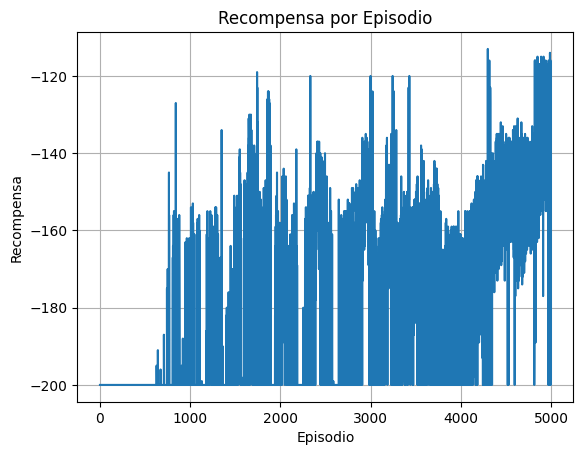

In [88]:
plt.plot(rewards)
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.title("Recompensa por Episodio")
plt.grid(True)
plt.show()

### Prueba del agente y grabación del video

- Se crea un entorno con render_mode="rgb_array" y se usa RecordVideo para grabar el episodio.
- El agente juega un episodio usando solo explotación (np.argmax).
- Al finalizar, se guarda el video en una carpeta local.


In [89]:
video_folder = "./mountaincar_videos-QLearning"
os.makedirs(video_folder, exist_ok=True)

env = gym.make('MountainCar-v0', render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
state_disc = discretize_state(state)
done = False
total_reward = 0

while not done:
    action = np.argmax(q_table[state_disc])
    result = env.step(action)
    if len(result) == 4:
        next_state, reward, done, _ = result
    else:
        next_state, reward, terminated, truncated, _ = result
        done = terminated or truncated

    state_disc = discretize_state(next_state)
    total_reward += reward

env.close()
print(f"Recompensa total del episodio grabado: {total_reward}")

Recompensa total del episodio grabado: -127.0


## DQN MountainCar

### Modelo DQN

Se crea una red neuronal simple:
- Entrada: estado del carro (posición y velocidad).
- Salida: valor Q para cada acción (izquierda, nada, derecha).
- Arquitectura: 2 capas ocultas con ReLU.


In [101]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

### Funciones auxiliares

- normalize_state: normaliza el estado continuo (posición, velocidad) para que esté entre 0 y 1.
- select_action: aplica la política e-greedy. A veces toma acción random (explora), a veces escoge la mejor según la red.


In [102]:
def normalize_state(state):
    low = np.array([-1.2, -0.07])
    high = np.array([0.6, 0.07])
    return (state - low) / (high - low)

def select_action(model, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state)
            q_values = model(state_tensor)
            return torch.argmax(q_values).item()

### Entrenamiento

- Se inicializa el entorno y la red.
- Se usa memoria de experiencia para guardar las transiciones.
- Se entrena por episodios:
  - Ejecuta acciones, guarda experiencias.
  - Cuando hay suficientes datos, se entrena con minibatches.
  - Se actualiza el modelo objetivo (target_model) cada episodio.
  - Se reduce epsilon para explorar menos con el tiempo.
- Cada 50 episodios se imprime el rendimiento promedio.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCar-v0')
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

model = DQN(input_dim=state_dim, output_dim=n_actions).to(device)
target_model = DQN(input_dim=state_dim, output_dim=n_actions).to(device)
target_model.load_state_dict(model.state_dict())

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

episodes = 500
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
memory = deque(maxlen=10000)
rewards = []
target_update_freq = 10

for ep in range(episodes):
    state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
    state = normalize_state(state)
    total_reward = 0
    done = False

    while not done:
        action = select_action(model, state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state_norm = normalize_state(next_state)
        memory.append((state, action, reward, next_state_norm, done))
        state = next_state_norm
        total_reward += reward

        if len(memory) >= batch_size:
            minibatch = random.sample(memory, batch_size)
            states, actions, rewards_batch, next_states, dones = zip(*minibatch)

            states = torch.tensor(states, dtype=torch.float32, device=device)
            actions = torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
            rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32, device=device)
            next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
            dones = torch.tensor(dones, dtype=torch.float32, device=device)

            q_values = model(states).gather(1, actions).squeeze(1)
            with torch.no_grad():
                max_next_q = target_model(next_states).max(1)[0]
                targets = rewards_batch + gamma * max_next_q * (1 - dones)

            loss = criterion(q_values, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if (ep + 1) % target_update_freq == 0:
        target_model.load_state_dict(model.state_dict())

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    rewards.append(total_reward)

    if (ep + 1) % 50 == 0:
        avg_reward = np.mean(rewards[-50:])
        print(f"Episode {ep + 1}, Avg Reward (last 50): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")


Episode 50, Avg Reward (last 50): -200.00, Epsilon: 0.778


### Prueba del agente y grabación en video

- Se prueba el agente ya entrenado, sin exploración (epsilon = 0).
- Se graba el episodio completo en un video.
- Se guarda el video en una carpeta (mountaincar_videos).


In [99]:
video_folder = "./mountaincar_videos-DQN"
env = gym.make('MountainCar-v0', render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)
state = normalize_state(env.reset()[0])
done = False
total_reward = 0

while not done:
    action = select_action(model, state, epsilon=0.0)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    next_state = normalize_state(next_state)
    state = next_state
    total_reward += reward

env.close()
print(f"Recompensa total del episodio grabado: {total_reward}")

Recompensa total del episodio grabado: -200.0


### Gráfica de recompensas

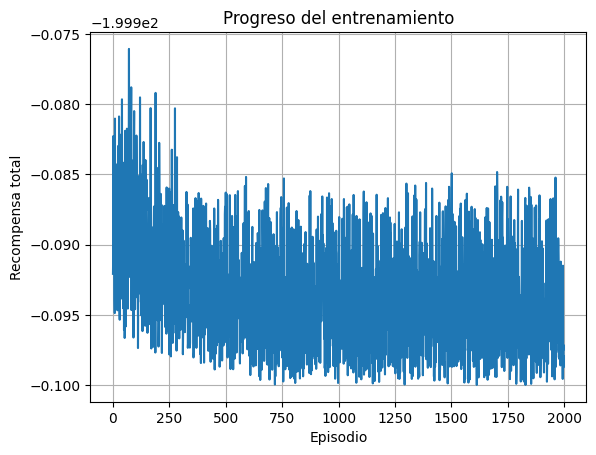

In [100]:
plt.plot(rewards)
plt.xlabel('Episodio')
plt.ylabel('Recompensa total')
plt.title('Progreso del entrenamiento')
plt.grid(True)
plt.show()

## Q-learning cart-pole

Starting Q-Learning training...
Episode 0, Avg Reward: 13.00, Epsilon: 0.995
Episode 100, Avg Reward: 21.25, Epsilon: 0.603
Episode 200, Avg Reward: 24.64, Epsilon: 0.365
Episode 300, Avg Reward: 35.92, Epsilon: 0.221
Episode 400, Avg Reward: 46.33, Epsilon: 0.134
Episode 500, Avg Reward: 46.46, Epsilon: 0.081
Episode 600, Avg Reward: 49.26, Epsilon: 0.049
Episode 700, Avg Reward: 61.40, Epsilon: 0.030
Episode 800, Avg Reward: 64.89, Epsilon: 0.018
Episode 900, Avg Reward: 57.28, Epsilon: 0.011


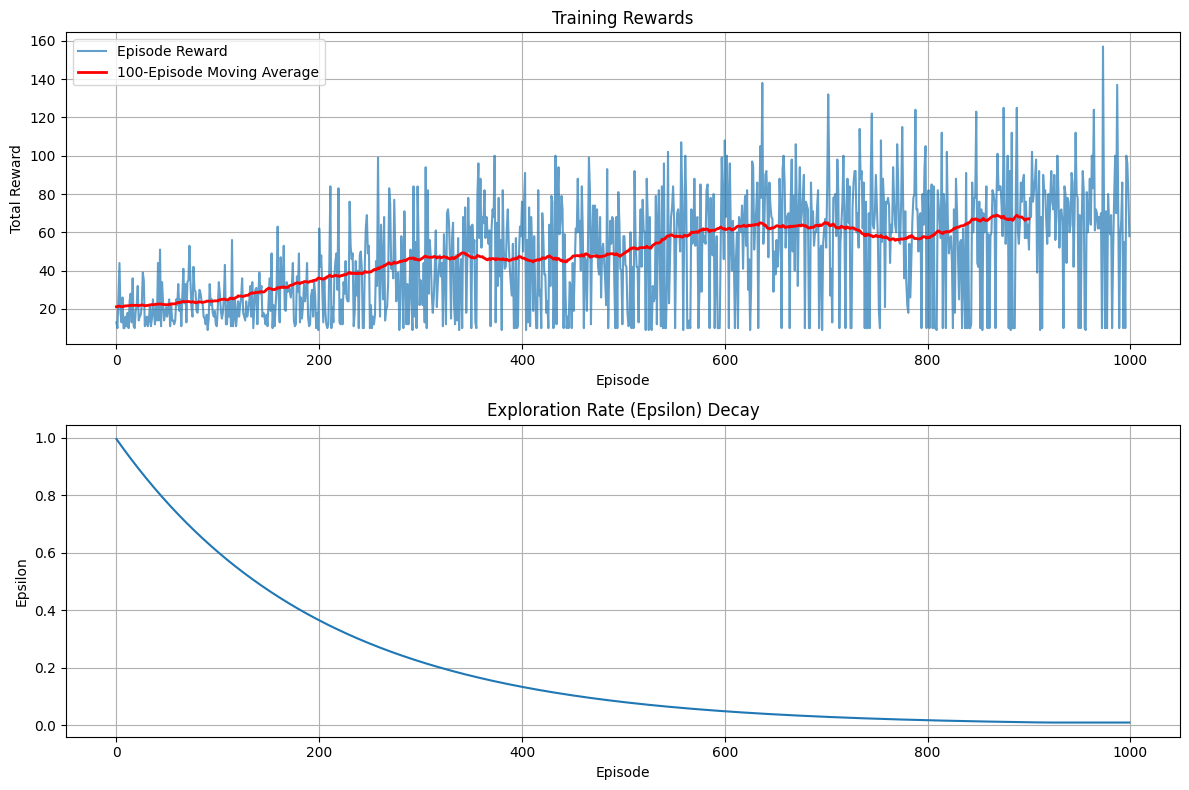


Q-table Analysis:
Number of states visited: 1325
Maximum Q-value: 17.073
Average maximum Q-value: 1.236
States preferring action 0 (left): 1015 (76.6%)
States preferring action 1 (right): 310 (23.4%)

Testing trained agent...
Test Episode 1: Reward = 94.0
Test Episode 2: Reward = 47.0
Test Episode 3: Reward = 76.0
Test Episode 4: Reward = 108.0
Test Episode 5: Reward = 58.0

Average test reward: 76.60

Model saved as 'cartpole_qlearning_model.pkl'


In [95]:
class QLearningAgent:
    def __init__(self, n_bins=20, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Q-Learning Agent for CartPole environment
        
        Args:
            n_bins: Number of bins for discretizing continuous state space
            learning_rate: Learning rate (alpha)
            discount_factor: Discount factor (gamma)
            epsilon: Initial exploration rate
            epsilon_decay: Decay rate for epsilon
            epsilon_min: Minimum epsilon value
        """
        self.n_bins = n_bins
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Q-table as defaultdict for sparse representation
        self.q_table = defaultdict(lambda: np.zeros(2))  # 2 actions in CartPole
        
        # State space bounds for CartPole
        self.state_bounds = [
            [-2.4, 2.4],      # Cart position
            [-2.0, 2.0],      # Cart velocity
            [-0.2095, 0.2095], # Pole angle
            [-2.0, 2.0]       # Pole angular velocity
        ]
        
    def discretize_state(self, state):
        """Convert continuous state to discrete state"""
        discrete_state = []
        for i, val in enumerate(state):
            # Clip values to bounds
            val = np.clip(val, self.state_bounds[i][0], self.state_bounds[i][1])
            # Normalize to [0, 1]
            normalized = (val - self.state_bounds[i][0]) / (self.state_bounds[i][1] - self.state_bounds[i][0])
            # Convert to discrete bin
            bin_idx = int(normalized * (self.n_bins - 1))
            discrete_state.append(bin_idx)
        return tuple(discrete_state)
    
    def choose_action(self, state, training=True):
        """Choose action using epsilon-greedy policy"""
        discrete_state = self.discretize_state(state)
        
        if training and np.random.random() < self.epsilon:
            # Explore: random action
            return np.random.randint(2)
        else:
            # Exploit: best action
            return np.argmax(self.q_table[discrete_state])
    
    def update_q_table(self, state, action, reward, next_state, done):
        """Update Q-table using Q-learning update rule"""
        discrete_state = self.discretize_state(state)
        discrete_next_state = self.discretize_state(next_state)
        
        # Current Q-value
        current_q = self.q_table[discrete_state][action]
        
        # Next Q-value (0 if terminal state)
        if done:
            next_q = 0
        else:
            next_q = np.max(self.q_table[discrete_next_state])
        
        # Q-learning update
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * next_q - current_q)
        self.q_table[discrete_state][action] = new_q
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def save_model(self, filename):
        """Save the Q-table to file"""
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.q_table), f)
    
    def load_model(self, filename):
        """Load Q-table from file"""
        with open(filename, 'rb') as f:
            q_dict = pickle.load(f)
            self.q_table = defaultdict(lambda: np.zeros(2), q_dict)

def train_agent(episodes=1000, render_every=100):
    """Train the Q-Learning agent"""
    env = gym.make('CartPole-v1')
    agent = QLearningAgent()
    
    # Training metrics
    rewards = []
    epsilons = []
    
    print("Starting Q-Learning training...")
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]  # Handle new gym API
        
        total_reward = 0
        done = False
        
        while not done:
            # Render environment occasionally
            if episode % render_every == 0 and episode > 0:
                env.render()
            
            # Choose and take action
            action = agent.choose_action(state, training=True)
            next_state, reward, done, truncated, info = env.step(action)
            
            # Handle new gym API
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            done = done or truncated
            
            # Update Q-table
            agent.update_q_table(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
        
        # Decay exploration rate
        agent.decay_epsilon()
        
        # Store metrics
        rewards.append(total_reward)
        epsilons.append(agent.epsilon)
        
        # Print progress
        if episode % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")
    
    env.close()
    return agent, rewards, epsilons

def test_agent(agent, episodes=10, render=True):
    """Test the trained agent"""
    env = gym.make('CartPole-v1', render_mode='human' if render else None)
    
    test_rewards = []
    
    print("\nTesting trained agent...")
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        total_reward = 0
        done = False
        
        while not done:
            if render:
                env.render()
            
            # Use trained policy (no exploration)
            action = agent.choose_action(state, training=False)
            next_state, reward, done, truncated, info = env.step(action)
            
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            done = done or truncated
            
            state = next_state
            total_reward += reward
        
        test_rewards.append(total_reward)
        print(f"Test Episode {episode + 1}: Reward = {total_reward}")
    
    env.close()
    avg_test_reward = np.mean(test_rewards)
    print(f"\nAverage test reward: {avg_test_reward:.2f}")
    return test_rewards

def plot_training_progress(rewards, epsilons):
    """Plot training metrics"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot rewards
    ax1.plot(rewards, alpha=0.7)
    ax1.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'), 'r-', linewidth=2)
    ax1.set_title('Training Rewards')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.legend(['Episode Reward', '100-Episode Moving Average'])
    ax1.grid(True)
    
    # Plot epsilon decay
    ax2.plot(epsilons)
    ax2.set_title('Exploration Rate (Epsilon) Decay')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Epsilon')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def analyze_q_table(agent):
    """Analyze the learned Q-table"""
    print(f"\nQ-table Analysis:")
    print(f"Number of states visited: {len(agent.q_table)}")
    
    # Find states with highest Q-values
    max_q_values = []
    for state, q_values in agent.q_table.items():
        max_q_values.append(np.max(q_values))
    
    print(f"Maximum Q-value: {np.max(max_q_values):.3f}")
    print(f"Average maximum Q-value: {np.mean(max_q_values):.3f}")
    
    # Action preference analysis
    action_preferences = []
    for state, q_values in agent.q_table.items():
        action_preferences.append(np.argmax(q_values))
    
    action_0_count = action_preferences.count(0)
    action_1_count = action_preferences.count(1)
    total_states = len(action_preferences)
    
    print(f"States preferring action 0 (left): {action_0_count} ({action_0_count/total_states*100:.1f}%)")
    print(f"States preferring action 1 (right): {action_1_count} ({action_1_count/total_states*100:.1f}%)")

if __name__ == "__main__":
    # Train the agent
    trained_agent, training_rewards, training_epsilons = train_agent(episodes=1000)
    
    # Plot training progress
    plot_training_progress(training_rewards, training_epsilons)
    
    # Analyze learned Q-table
    analyze_q_table(trained_agent)
    
    # Test the trained agent
    test_rewards = test_agent(trained_agent, episodes=5, render=False)
    
    # Save the trained model
    trained_agent.save_model('cartpole_qlearning_model.pkl')
    print("\nModel saved as 'cartpole_qlearning_model.pkl'")
    
    # Example of loading the model
    # new_agent = QLearningAgent()
    # new_agent.load_model('cartpole_qlearning_model.pkl')
    # test_agent(new_agent, episodes=3, render=False)